In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
rawData=pd.read_csv(r'data.csv')
#Importing the CSV File which is in the same folder

In [4]:
print(rawData.shape) #It has 11,894 rows and 5 columns

(11894, 5)


In [5]:
print(rawData.head())

         time  tavg  tmin  tmax  prcp
0  01-01-1990  23.2  17.0   NaN   0.0
1  02-01-1990  22.2  16.5  29.9   0.0
2  03-01-1990  21.8  16.3  30.7   0.0
3  04-01-1990  25.4  17.9  31.8   0.0
4  05-01-1990  26.5  19.3  33.7   0.0


In [6]:
rawData.isna().sum() #Seeing how many null values (Missing Values) are there for each column

time       0
tavg      11
tmin    2454
tmax    1907
prcp    4681
dtype: int64

In [7]:
# Since 'Average Temperature' Column has the least number of Missing Values
# We will only consider it for making the prediction model
avgTemp = rawData[['time','tavg']]

In [8]:
#Thus we now have a new Dataframe called "df"
#Now we will drop the remaining 11 null values of this new Dataframe
df=avgTemp.dropna()
df

,time,tavg
0,01-01-1990,23.2
1,02-01-1990,22.2
2,03-01-1990,21.8
3,04-01-1990,25.4
4,05-01-1990,26.5
...,...,...
11889,21-07-2022,27.6
11890,22-07-2022,28.3
11891,23-07-2022,28.2
11892,24-07-2022,28.1


In [9]:
#Now the Dataframe is ready for model-building: 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11883 entries, 0 to 11893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    11883 non-null  object 
 1   tavg    11883 non-null  float64
dtypes: float64(1), object(1)
memory usage: 278.5+ KB


In [10]:
# Making some basic Statistical central tendency measures for this Data
print("Maximum Average temperature: "+str(max(avgTemp['tavg']))+"°C\n")
print("Minimum Average temperature: "+str(min(avgTemp['tavg']))+"°C\n")

avgOfavgTemp = sum(avgTemp['tavg'])/len(avgTemp['tavg'])
median = avgTemp['tavg'].median()
sd = avgTemp['tavg'].std()
var=avgTemp['tavg'].var()

print("Mean Average temperature: "+"{:.2f}".format(avgOfavgTemp)+"°C\n")
print("Median Average temperature: "+"{:.2f}".format(median)+"°C\n")
print("Standard Deviation of Average temperature: "+"{:.2f}".format(sd)+"\n")
print("Variance of Average temperature: "+"{:.2f}".format(var)+"\n")

Maximum Average temperature: 33.7°C

Minimum Average temperature: 17.7°C

Mean Average temperature: nan°C

Median Average temperature: 28.10°C

Standard Deviation of Average temperature: 2.19

Variance of Average temperature: 4.79



<AxesSubplot:xlabel='Time', ylabel='Temperature in °C'>

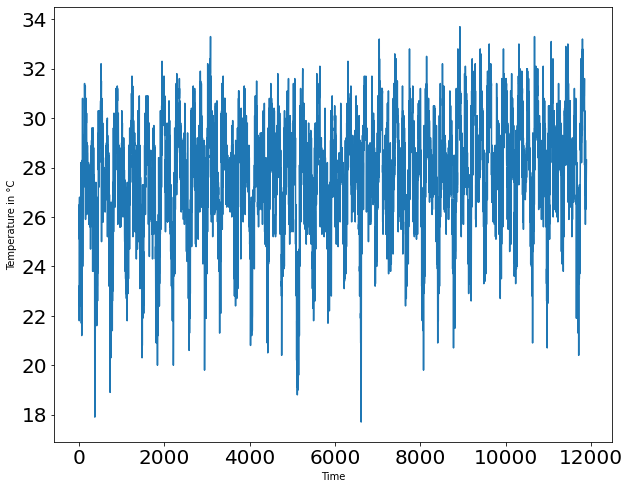

In [11]:
#Plotting the Data
df['tavg'].plot(ylabel="Temperature in °C", xlabel="Time",figsize=(10,8),fontsize=20) 

**Model 1: Facebook's Prophet Model for time-series data**

In [13]:
from prophet import Prophet
fbp = Prophet(yearly_seasonality=True)
# Fitting the model
df1=df.rename(columns = {"time":"ds","tavg":"y"}) 
train=df1.iloc[:8282]
test=df1.iloc[8282:] 
fbp.fit(train)
# We need to specify the number of days in we'll be predicting the temperature
fut = fbp.make_future_dataframe(periods=(3551+100))#Test + 100 days in future
forecast = fbp.predict(fut)

17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

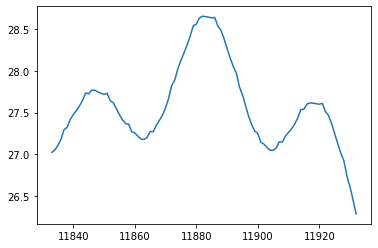

In [14]:
#The Forecasting of 100 days in future
forecast.iloc[-100:]['yhat'].plot()

<AxesSubplot:>

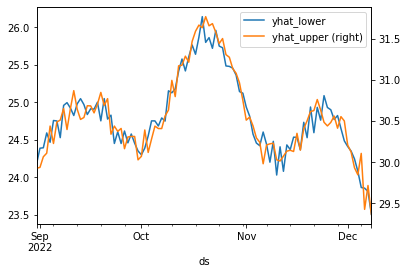

In [15]:
fig, ax = plt.subplots() 
forecast[-100:].plot(x = 'ds', y = 'yhat_lower', ax = ax) 
forecast[-100:].plot(x = 'ds', y = 'yhat_upper', ax = ax, secondary_y = True)

<AxesSubplot:>

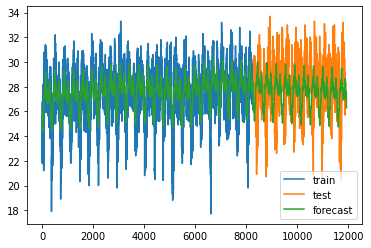

In [16]:
fig, ax = plt.subplots() 
train.plot(y = 'y', ax = ax, label="train")
test.plot(y = 'y', ax = ax, label="test")
forecast.plot(y = 'yhat', ax = ax, label="forecast") 

In [17]:
#Calculating RMSE (Root Mean Square Error) to get accuracy of this model: -
import math
import sklearn.metrics
forecast_testing=forecast.iloc[8293:11894]
mse = sklearn.metrics.mean_squared_error(test['y'],forecast_testing['yhat'])
print("Root Mean Square Error of the Test Data: "+str(mse))

Root Mean Square Error of the Test Data: 7.53055889597725


**Model 2: Autoregressive Model**

In [18]:
#utoregressive Model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

df2 = pd.read_csv(r'data.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df2=df2['tavg']
df2=df2.dropna()
x=df2.values
train_df2=x[:int(0.7*len(df2))]
test_df2=x[int(0.7*len(df2)):]

model = AutoReg(train_df2, lags=365)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 1.73608577e+00  8.36803202e-01 -1.07249600e-01  2.53699960e-02
  7.10995582e-03  3.43421903e-02  1.11014724e-02 -2.85077105e-03
  4.05753337e-03  3.92018608e-02 -1.61245718e-02  8.16660898e-03
  2.92823624e-02 -3.69279383e-02  2.64962610e-02 -1.56414624e-03
  1.50017647e-03 -7.99390846e-03  3.69403528e-03  3.64004255e-03
 -6.11457978e-03  3.72487030e-02 -3.64349014e-02  2.33231414e-03
  1.87497563e-02 -1.44209903e-02  1.52227512e-02 -6.82650510e-03
  2.31698879e-02 -1.75161126e-02  6.74089080e-03  1.66585858e-02
  1.19864692e-02 -2.63543632e-02  8.71452572e-03  2.33501257e-02
 -1.76967847e-02 -1.50397133e-02  1.31789738e-02 -1.04208301e-02
  9.42267330e-03 -5.31211365e-03  2.25015559e-02 -1.70594253e-02
 -4.40721082e-03  1.87965240e-02 -2.76959289e-03 -1.15777650e-03
  1.61746348e-02 -2.69823276e-02  2.06113761e-02 -2.14259903e-02
 -4.57183839e-03  7.15191585e-03 -4.97134426e-03 -7.03769530e-03
  1.64967382e-02 -1.39254127e-02  1.56381147e-02 -8.60584221e-03
  6.9507633

Root Mean Square: 1.733


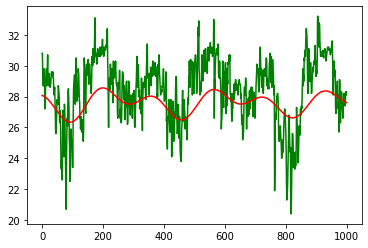

In [19]:
# make predictions
predictions = model_fit.predict(start=len(train_df2), end=len(train_df2)+len(test_df2)-1, dynamic=False)

rmse = sqrt(mean_squared_error(test_df2, predictions))
print('Root Mean Square: {:.3f}'.format(rmse))

# plot results
plt.plot(test_df2[-1000:],color='green')
plt.plot(predictions[-1000:], color='red')
plt.show()

**Model 3: Simple Exponential Smoothing**

In [23]:
#Model - Simple Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

df3 = pd.read_csv(r'data.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df3=df3['tavg']
df3=df3.dropna()

ses = SimpleExpSmoothing(df3).fit(smoothing_level=0.3,optimized=False)
ses_cast1 = ses.forecast(100).rename('alpha=0.15')

C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\raman\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='time'>

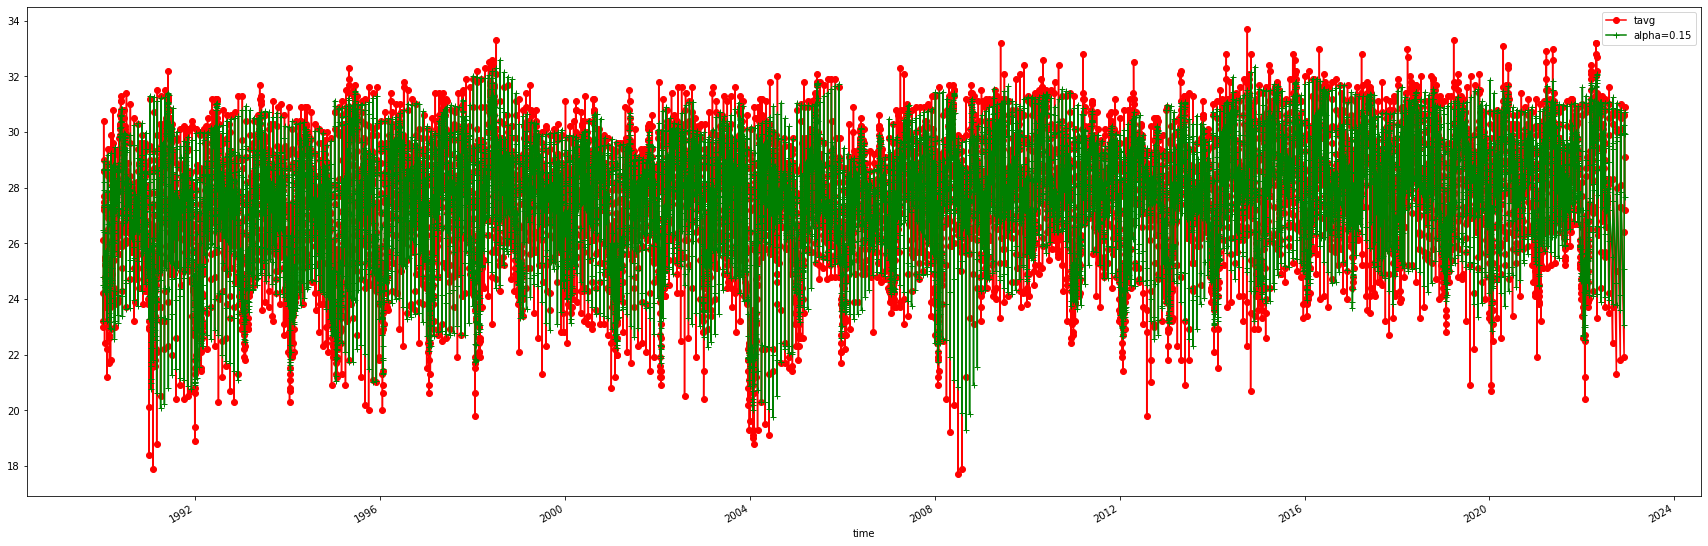

In [24]:
ax = df3.plot(marker='o', color='red', figsize=(30,10), legend=True)
ses_cast1.plot(marker='+', ax=ax, color='green', legend=True)
ses.fittedvalues.plot(marker='+', ax=ax, color='green')

In [27]:
#Accuracy using RMSE: -
mse = sklearn.metrics.mean_squared_error(df3,ses.fittedvalues)
print("Root Mean Square Error of the Test Data: "+str(mse))

Root Mean Square Error of the Test Data: 1.1267961528052335


**Model 4: Simple Moving Average**

In [28]:
Train=df.iloc[:8319]
Test=df.iloc[8319: ]
#Applying the "Simple Moving Average (SMA)" algorithm
sma=df.copy()
sma['predictedTemp']=sma['tavg'].rolling(3).mean()
sma

,time,tavg,predictedTemp
0,01-01-1990,23.2,NaN
1,02-01-1990,22.2,NaN
2,03-01-1990,21.8,22.400000
3,04-01-1990,25.4,23.133333
4,05-01-1990,26.5,24.566667
...,...,...,...
11889,21-07-2022,27.6,27.666667
11890,22-07-2022,28.3,27.766667
11891,23-07-2022,28.2,28.033333
11892,24-07-2022,28.1,28.200000


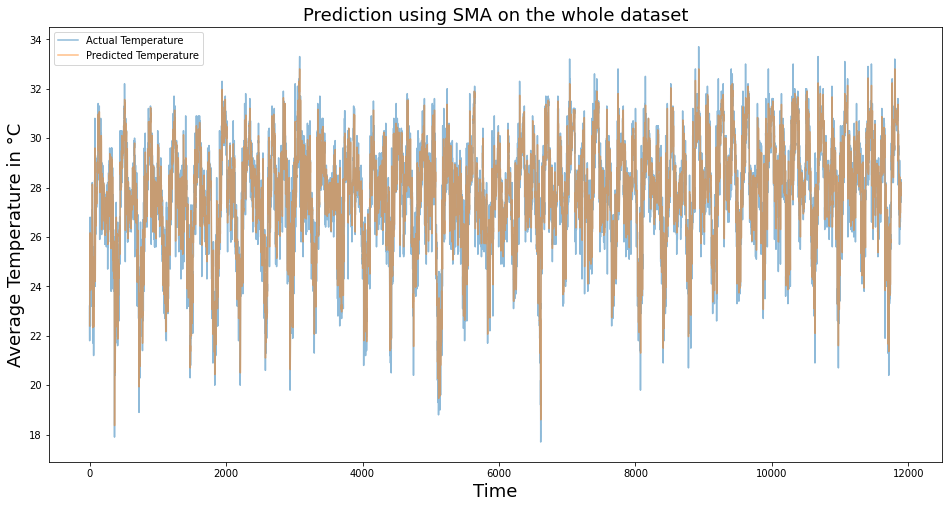

In [29]:
#Plotting the SMA

plt.figure(figsize=(16,8))
plt.plot(sma['tavg'], alpha=0.5, label='Actual Temperature')
plt.plot(sma['predictedTemp'], alpha=0.5, label='Predicted Temperature')

plt.title('Prediction using SMA on the whole dataset', fontsize=18)
plt.ylabel('Average Temperature in °C', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend()

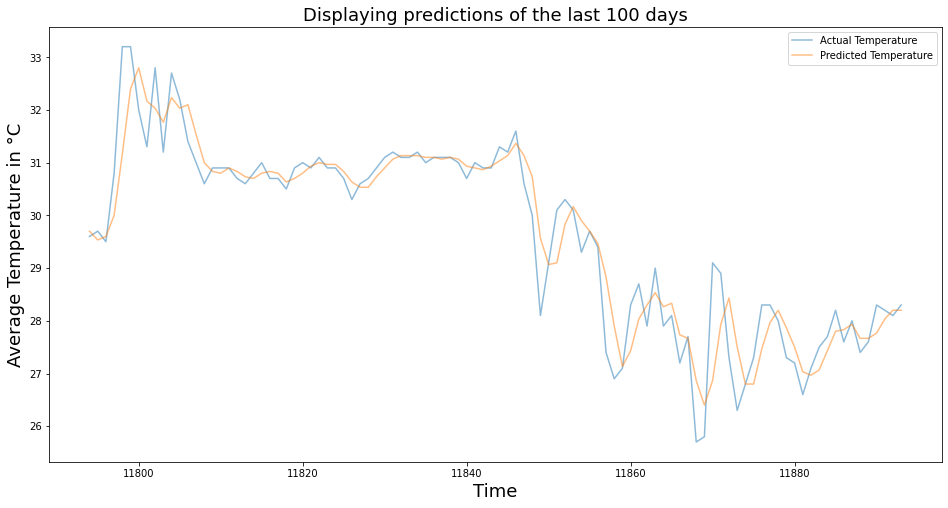

In [30]:
#The Same Graph for the last 100 days
plt.figure(figsize=(16,8))
plt.plot(sma['tavg'][11783:], alpha=0.5, label='Actual Temperature')
plt.plot(sma['predictedTemp'][11783:], alpha=0.5, label='Predicted Temperature')

plt.title('Displaying predictions of the last 100 days', fontsize=18)
plt.ylabel('Average Temperature in °C', fontsize=18)
plt.xlabel('Time', fontsize=18)

plt.legend()

In [32]:
#Finding Accuracy using RMSE (Root Mean Square Error): -
import math
import sklearn.metrics
mse = sklearn.metrics.mean_squared_error(Test['tavg'],sma['predictedTemp'].iloc[8319:])
print("Root Mean Square Error of the Test Data: "+str(mse))

Root Mean Square Error of the Test Data: 0.4513704950741988
